In [ ]:
# Number of Battels = 4 ,
# Number of Soldiers = 20 ,
# Population = 50
# Fitness =  Total number of wining with all individuals in population
# Scores : Win = 2 points  && tie = 1 point && loss = 0

# Selection = Tournament (Page 85 book) and SUS

# Crossover = 

# Mutation = Swap and Inversion Mutation (Page 107) and Scramble Mutation (Page 108)

# Survival Selection : Elitism (Page 89 book)
# In essence a trace is kept of the
# current fittest member, and it is always kept in the population. Thus if it is
# chosen in the group to be replaced, and none of the offspring being inserted
# into the population has equal or better fitness, then it is kept and one of the
# offspring is discarded



In [18]:
import random
import pandas as pd

def sums(length, total_sum):
    if length == 1:
        yield [total_sum,]
    else:
        for value in range(total_sum + 1):
            for permutation in sums(length - 1, total_sum - value):
                yield [value,] + permutation

def init(battles, soldiers, num_of_pop):
  all = list(sums(battles,soldiers))
  return random.sample(all, num_of_pop)

def battle_win_state(battle1, battle2):
  if battle1 == battle2:
    return 0
  elif battle1 > battle2:
    return 1
  else:
    return 2

def colonel_war_simulate(colonel1, colonel2):
  score1, score2 = 0, 0
  for i in range(len(colonel1)):
    win = battle_win_state(colonel1[i], colonel2[i])
    if win == 0:
      score1, score2 = score1 + 1, score2 + 1
    elif win == 1:
      score1 = score1 + 2
    else:
      score2 = score2 + 2
  return score1, score2

def colonel_win_state(colonel1, colonel2):
  score1, score2 = colonel_war_simulate(colonel1, colonel2)
  if score1 >= score2:
    return 1
  return 2

def fitness_function(chromosome, population):
  fitness = 0
  for p in population:
    if colonel_win_state(chromosome, p) == 1:
      fitness = fitness + 1
  return fitness

def _fitness_function(chromosome, population):
  fitness = 0
  for i, p in population:
    if colonel_win_state(chromosome, p) == 1:
      fitness = fitness + 1
  return fitness

def selection(num_of_chromosomes, population):
  current_member = 1
  parents = []
  while current_member <= num_of_chromosomes:
    subsample = random.sample(list(enumerate(population)), TOURNAMENT_BIN)
    parent = max(subsample, key= lambda x: _fitness_function(x[1], subsample))
    parents.append(parent)
    current_member = current_member + 1
  return parents

def selection_sus(num_of_chromosomes, population):
  current_member = 1
  parents = []
  step = 1 / num_of_chromosomes
  fitness_proportions = fitness_proportionate(population)
  start = random.random()
  selected = 0
  while current_member <= num_of_chromosomes:
    for i in range(len(population)):
      if start >= fitness_proportions[i]:
        selected = i
      else:
        break
    parents.append((selected, population[selected]))
    start = (start + step) if (start + step) <= 1 else ((start + step) - 1)
  return parents

def fitness_proportionate(population):
  fitness_proportions = list(map(lambda x: fitness_function(x, population), population))
  sum_of_fitnesses = sum(fitness_proportions)
  fitness_proportions[0] = fitness_proportions[0] / sum_of_fitnesses
  for i in range(1, len(fitness_proportions)):
    fitness_proportions[i] = fitness_proportions[i] / sum_of_fitnesses
    fitness_proportions[i] = fitness_proportions[i-1] + fitness_proportions[i]
  return fitness_proportions

def crossover(parent1, parent2):
  point = random.randint(1, NUM_OF_BATTLES - 2)
  child1 = parent2[0:point] + parent1[point:]
  child2 = parent1[0:point] + parent2[point:]
  child1 = fix_child(child1)
  child2 = fix_child(child2)
  return child1, child2


def fix_child(child):
  genes_sum = sum(child)
  if genes_sum == NUM_OF_SOLDIERS:
    return child
  elif genes_sum < NUM_OF_SOLDIERS:
    needed = NUM_OF_SOLDIERS - genes_sum
    while needed > 0:
      min_index = child.index(min(child))
      child[min_index] = child[min_index] + 1
      needed = needed - 1
  else:
    extra = genes_sum - NUM_OF_SOLDIERS
    while extra > 0:
      max_index = child.index(max(child))
      child[max_index] = child[max_index] - 1
      extra = extra - 1
  return child

def mutation1(child):
  if random.randint(1,100) <= MUTATION_PROB:
    idx1 = random.randint(0, NUM_OF_BATTLES - 1)
    idx2 = random.randint(0, NUM_OF_BATTLES - 1)
    temp = child[idx1]
    child[idx1] = child[idx2]
    child[idx2] = temp
  return child

def mutation2(child):
  if random.randint(1,100) <= MUTATION_PROB:
    idx1 = random.randint(0, NUM_OF_BATTLES - 2)
    idx2 = random.randint(idx1, NUM_OF_BATTLES - 1)
    child = child[0: idx1] + list(reversed(child[idx1 : idx2 + 1])) + child[idx2 + 1:]
  return child

def survival_selection(child1, child2, p1_index, p2_index, population):
  fitness_list = pd.Series([fitness_function(x, population) for x in population])
  elites_idx = fitness_list.nlargest(NUM_OF_ELITES).index.values.tolist()
  log(elites_idx[0], fitness_list, population)
  ch1_fitness, ch2_fitness = fitness_function(child1, population), fitness_function(child2, population)
  p1_fitness, p2_fitness = fitness_function(population[p1_index], population), fitness_function(population[p2_index], population)
  if p1_index not in elites_idx or p1_fitness < ch1_fitness:
    population[p1_index] = child1
  if p2_index not in elites_idx or p2_fitness < ch2_fitness:
    population[p2_index] = child2
  return population

def log(best_fitness_idx, fitness_list, population):
  best_fitness_log.append(fitness_list[best_fitness_idx])
  fitness_mean_log.append(fitness_list.mean())
  best_strategy_log.append(population[best_fitness_idx])


def train(iteration, population):
  while iteration>0:
    parents = selection(2, population)
    child1, child2 = crossover(parents[0][1], parents[1][1])
    child1, child2 = mutation1(child1), mutation1(child2)
    population = survival_selection(child1, child2, parents[0][0], parents[1][0], population)
    iteration = iteration - 1

NUM_OF_BATTLES = 5
NUM_OF_SOLDIERS = 20
NUM_OF_POPULATION = 50
TOURNAMENT_BIN = 10
ELITISM_PROB = 10/100
NUM_OF_ELITES = int(NUM_OF_POPULATION * ELITISM_PROB)
MUTATION_PROB = 80

best_fitness_log = []
fitness_mean_log = []
best_strategy_log = []

population1 = init(NUM_OF_BATTLES, NUM_OF_SOLDIERS, NUM_OF_POPULATION)
train(30, population1.copy())
# colonel_win_state([3, 1, 8, 8], [3, 1, 9, 11])
# fitness_function([3, 1, 8, 8], population)
# selection1(2, population, 2)

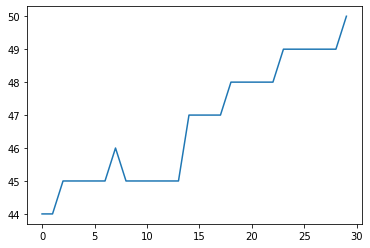

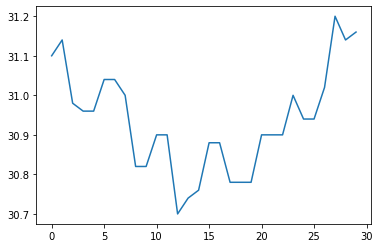

In [19]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(best_fitness_log))), best_fitness_log)
plt.show()
plt.plot(list(range(len(fitness_mean_log))), fitness_mean_log)
plt.show()

In [21]:
print(best_strategy_log)

[[8, 2, 2, 5, 3], [3, 3, 2, 7, 5], [3, 5, 5, 4, 3], [3, 5, 5, 4, 3], [3, 5, 5, 4, 3], [3, 0, 5, 6, 6], [3, 0, 5, 6, 6], [3, 3, 2, 7, 5], [3, 0, 5, 6, 6], [3, 0, 5, 6, 6], [3, 0, 5, 6, 6], [3, 0, 5, 6, 6], [3, 0, 5, 6, 6], [3, 0, 5, 6, 6], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 4, 4, 4], [4, 4, 4, 4, 4], [4, 4, 4, 4, 4]]


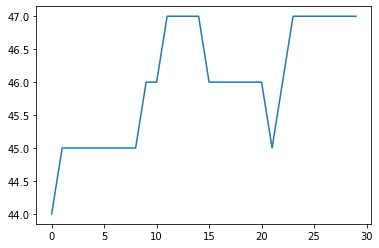

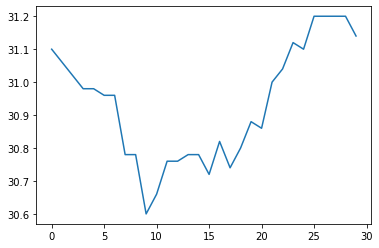

In [22]:
best_fitness_log = []
fitness_mean_log = []
best_strategy_log = []

def train2(iteration, population):
  while iteration>0:
    parents = selection(2, population)
    child1, child2 = crossover(parents[0][1], parents[1][1])
    child1, child2 = mutation2(child1), mutation2(child2)
    population = survival_selection(child1, child2, parents[0][0], parents[1][0], population)
    iteration = iteration - 1

train2(30, population1.copy())
plt.plot(list(range(len(best_fitness_log))), best_fitness_log)
plt.show()
plt.plot(list(range(len(fitness_mean_log))), fitness_mean_log)
plt.show()

In [24]:
print(best_strategy_log)

[[8, 2, 2, 5, 3], [4, 3, 5, 4, 4], [4, 3, 5, 4, 4], [4, 3, 5, 4, 4], [4, 3, 5, 4, 4], [4, 3, 5, 4, 4], [4, 3, 5, 4, 4], [4, 3, 5, 5, 3], [4, 3, 5, 5, 3], [4, 3, 5, 5, 3], [4, 3, 5, 5, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 3, 5, 5, 3], [4, 3, 5, 5, 3], [4, 3, 5, 5, 3], [4, 3, 5, 5, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [5, 5, 5, 0, 5], [5, 5, 5, 0, 5], [5, 5, 5, 0, 5], [5, 5, 5, 0, 5], [5, 5, 5, 0, 5], [4, 4, 5, 4, 3]]


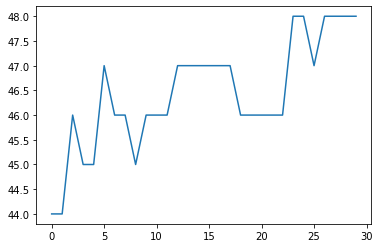

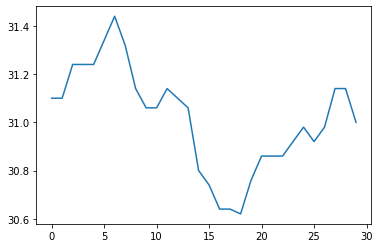

In [25]:
best_fitness_log = []
fitness_mean_log = []
best_strategy_log = []

def train3(iteration, population):
  while iteration>0:
    parents = selection_sus(2, population)
    child1, child2 = crossover(parents[0][1], parents[1][1])
    child1, child2 = mutation1(child1), mutation1(child2)
    population = survival_selection(child1, child2, parents[0][0], parents[1][0], population)
    iteration = iteration - 1

train2(30, population1.copy())
plt.plot(list(range(len(best_fitness_log))), best_fitness_log)
plt.show()
plt.plot(list(range(len(fitness_mean_log))), fitness_mean_log)
plt.show()

In [26]:
print(best_strategy_log)

[[8, 2, 2, 5, 3], [8, 2, 2, 5, 3], [3, 2, 2, 7, 6], [3, 2, 2, 7, 6], [3, 2, 2, 7, 6], [6, 2, 5, 4, 3], [6, 2, 5, 4, 3], [6, 2, 5, 4, 3], [3, 2, 2, 7, 6], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 4, 5, 4, 3], [4, 5, 2, 7, 2], [4, 5, 2, 7, 2], [4, 5, 2, 7, 2], [4, 5, 2, 7, 2], [4, 5, 2, 7, 2], [4, 5, 2, 7, 2], [4, 5, 2, 7, 2]]


In [27]:
import random
import pandas as pd
import math

def sums(length, total_sum):
    if length == 1:
        yield [total_sum,]
    else:
        for value in range(total_sum + 1):
            for permutation in sums(length - 1, total_sum - value):
                yield [value,] + permutation

def init(battles, soldiers, num_of_pop):
  all = list(sums(battles,soldiers))
  return random.sample(all, num_of_pop)

def battle_win_state(battle1, battle2):
  extra = math.fabs(battle1 - battle2)
  if battle1 == battle2:
    return (0, extra)
  elif battle1 > battle2:
    return (1, extra)
  else:
    return (2, extra)

def colonel_war_simulate(colonel1, colonel2):
  score1, score2 = 0, 0
  for i in range(len(colonel1)):
    extra, win = battle_win_state(colonel1[i], colonel2[i])
    if win == 0:
      score1, score2 = score1 + 1, score2 + 1
    elif win == 1:
      score1 = score1 + 2
      colonel1 = redeploy(extra - 1, colonel1, i + 1)
    else:
      score2 = score2 + 2
      colonel2 = redeploy(extra - 1, colonel2, i + 1)
  return score1, score2

def redeploy(extra, colonel, index):
  if extra <= 1:
    return colonel
  colonel[index - 1] = colonel[index - 1] - extra
  for i in range(len(colonel) - 1):
    if extra == 0:
      break
    index = 0 if index >= len(colonel) else index
    amount = math.ceil(R_F * extra)
    colonel[index] = colonel[index] + amount
    extra = extra - amount
    index = index + 1
  return colonel

def colonel_win_state(colonel1, colonel2):
  score1, score2 = colonel_war_simulate(colonel1, colonel2)
  if score1 >= score2:
    return 1
  return 2

def fitness_function(chromosome, population):
  fitness = 0
  for p in population:
    if colonel_win_state(chromosome, p) == 1:
      fitness = fitness + 1
  return fitness

def _fitness_function(chromosome, population):
  fitness = 0
  for i, p in population:
    if colonel_win_state(chromosome, p) == 1:
      fitness = fitness + 1
  return fitness

def selection(num_of_chromosomes, population):
  current_member = 1
  parents = []
  while current_member <= num_of_chromosomes:
    subsample = random.sample(list(enumerate(population)), TOURNAMENT_BIN)
    parent = max(subsample, key= lambda x: _fitness_function(x[1], subsample))
    parents.append(parent)
    current_member = current_member + 1
  return parents
  
def crossover(parent1, parent2):
  point = random.randint(1, NUM_OF_BATTLES - 2)
  child1 = parent2[0:point] + parent1[point:]
  child2 = parent1[0:point] + parent2[point:]
  child1 = fix_child(child1)
  child2 = fix_child(child2)
  return child1, child2


def fix_child(child):
  genes_sum = sum(child)
  if genes_sum == NUM_OF_SOLDIERS:
    return child
  elif genes_sum < NUM_OF_SOLDIERS:
    needed = NUM_OF_SOLDIERS - genes_sum
    while needed > 0:
      min_index = child.index(min(child))
      child[min_index] = child[min_index] + 1
      needed = needed - 1
  else:
    extra = genes_sum - NUM_OF_SOLDIERS
    while extra > 0:
      max_index = child.index(max(child))
      child[max_index] = child[max_index] - 1
      extra = extra - 1
  return child

def mutation1(child):
  if random.randint(1,100) <= MUTATION_PROB:
    idx1 = random.randint(0, NUM_OF_BATTLES - 1)
    idx2 = random.randint(0, NUM_OF_BATTLES - 1)
    temp = child[idx1]
    child[idx1] = child[idx2]
    child[idx2] = temp
  return child

def survival_selection(child1, child2, p1_index, p2_index, population):
  fitness_list = pd.Series([fitness_function(x, population) for x in population])
  elites_idx = fitness_list.nlargest(NUM_OF_ELITES).index.values.tolist()
  log(elites_idx[0], fitness_list, population)
  ch1_fitness, ch2_fitness = fitness_function(child1, population), fitness_function(child2, population)
  p1_fitness, p2_fitness = fitness_function(population[p1_index], population), fitness_function(population[p2_index], population)
  if p1_index not in elites_idx or p1_fitness < ch1_fitness:
    population[p1_index] = child1
  if p2_index not in elites_idx or p2_fitness < ch2_fitness:
    population[p2_index] = child2
  return population

def log(best_fitness_idx, fitness_list, population):
  best_fitness_log.append(fitness_list[best_fitness_idx])
  fitness_mean_log.append(fitness_list.mean())
  best_strategy_log.append(population[best_fitness_idx])


def train(iteration, population):
  while iteration>0:
    parents = selection(2, population)
    child1, child2 = crossover(parents[0][1], parents[1][1])
    child1, child2 = mutation1(child1), mutation1(child2)
    population = survival_selection(child1, child2, parents[0][0], parents[1][0], population)
    iteration = iteration - 1

NUM_OF_BATTLES = 4
NUM_OF_SOLDIERS = 20
NUM_OF_POPULATION = 50
TOURNAMENT_BIN = 10
ELITISM_PROB = 10/100
NUM_OF_ELITES = int(NUM_OF_POPULATION * ELITISM_PROB)
MUTATION_PROB = 80
R_F = 0.5
best_fitness_log = []
fitness_mean_log = []
best_strategy_log = []

population = init(NUM_OF_BATTLES, NUM_OF_SOLDIERS, NUM_OF_POPULATION)
train(30, population1.copy())

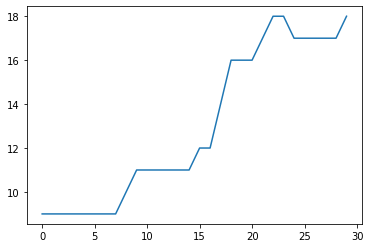

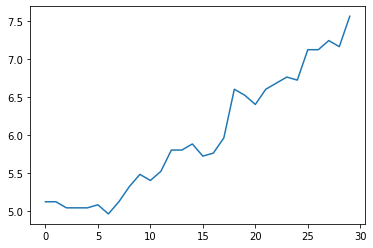

In [28]:
plt.plot(list(range(len(best_fitness_log))), best_fitness_log)
plt.show()
plt.plot(list(range(len(fitness_mean_log))), fitness_mean_log)
plt.show()

In [29]:
print(best_strategy_log)

[[4, 1, 2, 3, 10], [4, 1, 2, 3, 10], [4, 1, 2, 3, 10], [4, 1, 2, 3, 10], [4, 1, 2, 3, 10], [4, 1, 2, 3, 10], [4, 1, 2, 3, 10], [3, 7, 5, 3, 2], [3, 7, 5, 3, 2], [3, 7, 5, 3, 2], [3, 7, 5, 3, 2], [3, 7, 5, 3, 2], [3, 7, 5, 3, 2], [3, 7, 5, 3, 2], [3, 7, 5, 3, 2], [4, 5, 2, 3, 6], [4, 5, 2, 3, 6], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 4, 5, 3, 4], [4, 5, 2, 3, 6], [4, 5, 2, 3, 6]]
